<a href="https://colab.research.google.com/github/KevinHern/SP2-SFD/blob/master/SignatureForgeryDetection/AI-Research/Signer_Signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
%load_ext tensorboard

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Input, Lambda, Subtract, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend as K
import getpass as gp
import sys
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import permutations, combinations
from datetime import date

# To reproduce same results, we seet randomness to 1999
np.random.seed(1999)

# Generating Genuine and Forged Pairs

In [3]:
# Total Signers = 55
pool_size = 55
total_signers = 55
active_signatures_classification = False

# Generating Signers
signers_index = list(i+1 for i in range(pool_size))
signers = random.sample(signers_index, total_signers)

'''
  This is a machine learning approach. That means, every signer will be treated as an independent class and every signer
  has 2 subclasses: forged and genuine signatures.
  With this in mind, this model does not scale but only works with what is available.
  In this approach, every signer has his/her own model to detect forged signatures. The objective is that with every new signer, it is only needed to 
  train an exclusive model for him/her.

  We are going to pick N signers, and for each signer there are there are 24 genuine and 24 forged signatures.
  From each group, will select 16 for training, 4 for validation and 4 for testing
  For each signer, this gives a total of:
  * 32 train images (16 genuine and 16 forged)
  * 8 validation (4 genuine and 4 forged) images
  * 8 test (4 genuine and 4 forged) images

  This gives a total of:
  * 32*N Train images  (120 genuine and 16 forged)
  * 8*N validation images (30 genuine and 30 forged)
  * 8*N test images (30 genuine and 30 forged)

'''

# Generating signatures
total_signatures = 24

# Selecting Signatures from the 24 pool. The Indexes are valid in both genuine and forged
sign_train = 16
sign_valid = 4
sign_test = 4

signatures_index = list(i+1 for i in range(total_signatures))
sign_train_index = sorted(np.random.choice(signatures_index, sign_train, replace=False))
sign_valid_index = sorted(np.random.choice([x for x in signatures_index if x not in sign_train_index], sign_valid, replace=False))
sign_test_index = sorted(np.random.choice([x for x in signatures_index if x not in sign_train_index and x not in sign_valid_index], sign_valid, replace=False))


In [4]:
sign_test_index

[1, 5, 19, 20]

In [ ]:
sign_train_index, sign_valid_index, sign_test_index

([2, 3, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 21, 22, 24],
 [4, 12, 13, 23],
 [1, 5, 19, 20])

In [ ]:
len(signers), len(sign_train_index), len(sign_test_index), len(sign_valid_index)

(55, 16, 4, 4)

# Mapping Signers with Genuine and Forged Pairs

In [ ]:
# Here we define the labels for each signature
# Even classes are genuine while odd classes are forged

train_signers = []
for i in range(len(signers)):
  for index in sign_train_index:
    train_signers += [[signers[i], index, i, 0]]    # Forged Signature
    train_signers += [[signers[i], index, i, 1]]    # Genuine Signature


test_signers = []
for i in range(len(signers)):
  for index in sign_test_index:
    test_signers += [[signers[i], index,  i, 0]]    # Forged Signature
    test_signers += [[signers[i], index,  i, 1]]    # Genuine Signature


validation_signers = []
for i in range(len(signers)):
  for index in sign_valid_index:
    validation_signers += [[signers[i], index,  i, 0]]    # Forged Signature
    validation_signers += [[signers[i], index,  i, 1]]    # Genuine Signature

In [ ]:
random.shuffle(train_signers)
random.shuffle(test_signers)
random.shuffle(validation_signers)

In [ ]:
# Format: [Signer, SignatureId, Signer Class, Signature Class]
train_signers

[[14, 10, 32, 0],
 [46, 15, 37, 0],
 [40, 10, 6, 0],
 [3, 7, 15, 0],
 [51, 11, 28, 0],
 [48, 14, 44, 1],
 [40, 22, 6, 0],
 [12, 8, 12, 0],
 [40, 9, 6, 1],
 [22, 17, 23, 0],
 [23, 24, 54, 0],
 [11, 9, 8, 0],
 [50, 7, 27, 1],
 [1, 18, 35, 1],
 [3, 14, 15, 0],
 [19, 21, 41, 1],
 [3, 2, 15, 1],
 [24, 24, 50, 0],
 [52, 14, 17, 1],
 [34, 3, 51, 1],
 [49, 14, 16, 0],
 [8, 2, 5, 0],
 [50, 17, 27, 0],
 [43, 14, 30, 0],
 [1, 15, 35, 0],
 [50, 18, 27, 1],
 [45, 15, 0, 1],
 [39, 2, 3, 0],
 [54, 21, 4, 1],
 [32, 2, 14, 0],
 [23, 6, 54, 1],
 [17, 21, 7, 0],
 [7, 16, 39, 0],
 [54, 22, 4, 1],
 [18, 3, 13, 0],
 [16, 14, 9, 1],
 [6, 18, 40, 1],
 [26, 24, 25, 0],
 [2, 22, 48, 0],
 [54, 21, 4, 0],
 [17, 9, 7, 0],
 [46, 3, 37, 1],
 [44, 14, 10, 0],
 [44, 15, 10, 1],
 [15, 3, 19, 0],
 [26, 7, 25, 1],
 [20, 21, 45, 0],
 [33, 24, 18, 1],
 [31, 7, 29, 1],
 [34, 24, 51, 0],
 [51, 21, 28, 1],
 [38, 18, 47, 1],
 [9, 22, 24, 0],
 [45, 18, 0, 1],
 [44, 17, 10, 0],
 [21, 9, 49, 0],
 [38, 9, 47, 1],
 [48, 24, 44, 0],

# Model Definition - Personalized Convolusional

## Architecture 1 - Layers Definition

In [ ]:
def create_arch1(input_shape, ll_num_classes, ll_activation):
  seq = Sequential()
  seq.add(Convolution2D(96, kernel_size=11, strides=(4,4), activation='relu', name='conv1_1', input_shape= input_shape, 
                      kernel_initializer='glorot_uniform'))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
  seq.add(ZeroPadding2D((2, 2)))
  
  seq.add(Convolution2D(filters=256, kernel_size=5, strides=(1,1), activation='relu', name='conv2_1', kernel_initializer='glorot_uniform'))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(Dropout(0.3))
  seq.add(ZeroPadding2D((1, 1)))
  
  seq.add(Convolution2D(filters=384, kernel_size=3, strides=(1,1), activation='relu', name='conv3_1', kernel_initializer='glorot_uniform'))
  seq.add(ZeroPadding2D((1, 1)))
  
  seq.add(Convolution2D(filters=256, kernel_size=3, strides=(1,1), activation='relu', name='conv3_2', kernel_initializer='glorot_uniform'))    
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(Dropout(0.3))
  seq.add(Flatten(name='flatten'))
  seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
  seq.add(Dropout(0.5))
  
  seq.add(Dense(ll_num_classes, kernel_regularizer=l2(0.0005), activation=ll_activation, kernel_initializer='glorot_uniform')) # softmax changed to relu

  return seq

## Architecture 2 - Layers Definition

In [ ]:
def create_arch2(input_shape, ll_num_classes, ll_activation):
  seq = Sequential()
  seq.add(Convolution2D(256, kernel_size=5, strides=(1,1), activation='relu', name='conv1_1', input_shape= input_shape, 
                      kernel_initializer='glorot_uniform'))
  seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
  seq.add(MaxPooling2D((2,2)))   
  
  seq.add(Dropout(0.35))
  seq.add(Convolution2D(filters=512, kernel_size=3, strides=(1,1), activation='relu', name='conv2_1', kernel_initializer='glorot_uniform'))
  seq.add(Convolution2D(filters=256, kernel_size=2, strides=(2,2), activation='relu', name='conv2_2', kernel_initializer='glorot_uniform'))
  seq.add(MaxPooling2D((3,3)))
  seq.add(ZeroPadding2D((2, 2)))
  

  seq.add(Convolution2D(filters=256, kernel_size=2, activation='relu', name='conv3_2', kernel_initializer='glorot_uniform'))
  seq.add(MaxPooling2D((3,3)))
  seq.add(Dropout(0.3))

  seq.add(Flatten(name='flatten'))
  seq.add(Dense(1024, activation='relu', kernel_initializer='glorot_uniform'))
  seq.add(Dropout(0.5))
  
  seq.add(Dense(ll_num_classes, activation=ll_activation, kernel_initializer='glorot_uniform'))

  return seq

## Model - Signer Classification

In [ ]:
input_shape = (155, 220, 1)
architecture = 2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 151, 216, 256)     6656      
_________________________________________________________________
batch_normalization (BatchNo (None, 151, 216, 256)     604       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 108, 256)      0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 108, 256)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 73, 106, 512)      1180160   
_________________________________________________________________
conv2_2 (Conv2D)             (None, 36, 53, 256)       524544    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 17, 256)       0

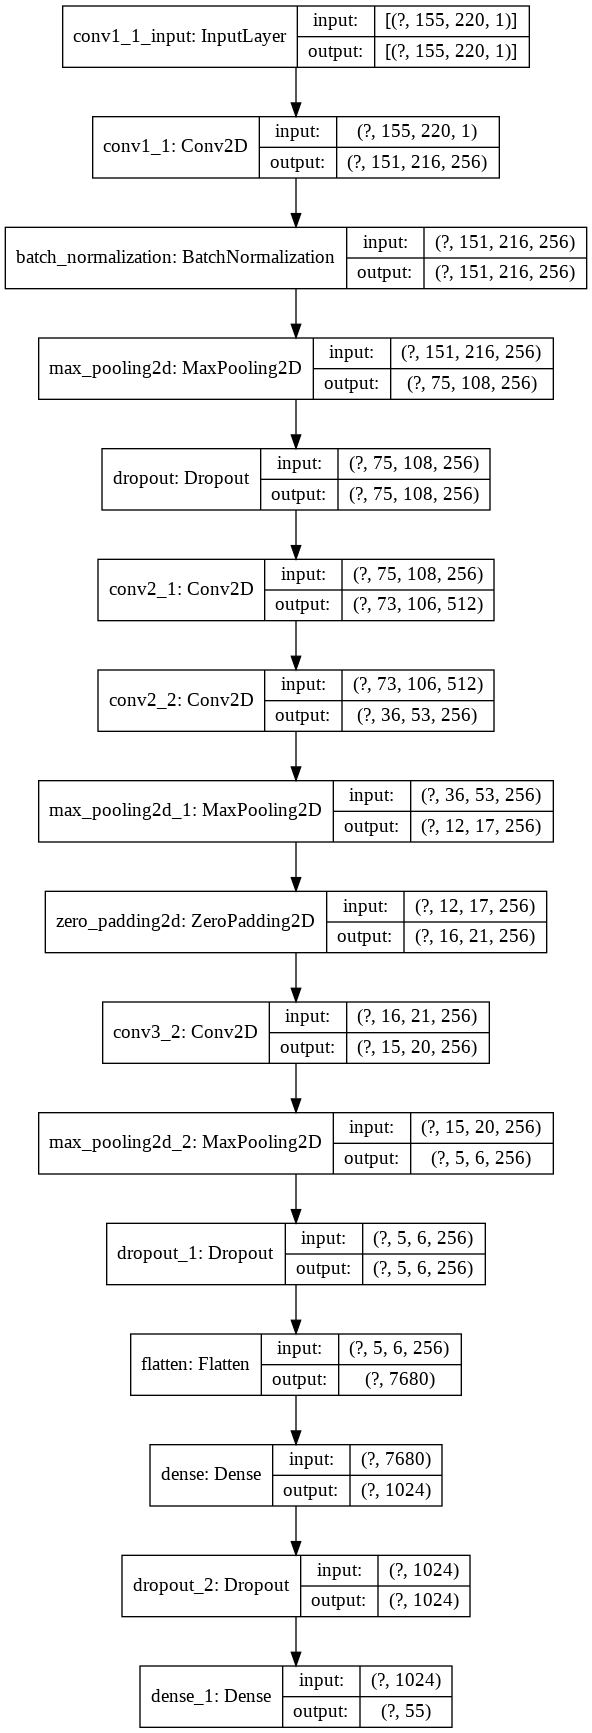

In [ ]:
model_signer_classification = object
if architecture == 1:
  # Architecture 1
  model_signer_classification = create_arch1(input_shape, len(signers), 'softmax')
else:
  # Architecture 2
  model_signer_classification = create_arch2(input_shape, len(signers), 'softmax')


# Compilation
model_signer_classification.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_signer_classification.summary()
tf.keras.utils.plot_model(model_signer_classification, show_shapes=True)

## Model - Signature Classification

In [ ]:
# Compilation
models_signatures = []
for i in range(total_signers):
  if architecture == 1:
    # Architecture 1
    models_signatures += [create_arch1(input_shape, 1, 'sigmoid')]
  else:
    # Architecture 2
    models_signatures += [create_arch2(input_shape, 1, 'sigmoid')]

  
for i in range(total_signers):
  models_signatures[i].compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

# Training

## Helping Training Functions Definitions

In [ ]:
# Directories
routeOriginal = '/content/drive/My Drive/signatures/full_org/'
routeForged = '/content/drive/My Drive/signatures/full_forg/'
routeOriginalProcessed = '/content/drive/My Drive/signatures/full_org_proc/'
routeForgedProcessed = '/content/drive/My Drive/signatures/full_forg_proc/'

In [ ]:
# Multriprocessing. There are A TON of IMAGES TO LOAD
from multiprocessing import Process, Lock, Manager

# Parallelizable Function "Fetch images"
def load_processed_image(pid, images_to_fetch, mode, sigs_pool, image_list, label_list, lock_sigs, lock_batch):
  #print("Process #", pid, "has to fetch: ", images_to_fetch, "images")
  for i in range(images_to_fetch):

    # Fetch 4 images, stop when there is none left
    lock_sigs.acquire()
    #print("\nProcess No.", str(pid), "Lock Acquired. List is:")
    #print(signatures)
    #print("Actual len of signatures: ", len(sigs_pool))
    if len(sigs_pool) == 0:
      lock_sigs.release()
      break
    single_sig = sigs_pool.pop(0)
    #signatures = signatures + [single_sig]
    #print("\nProcess No.", str(pid), "List after pop:")
    #print(signatures)
    lock_sigs.release()
    #print("\nProcess No.", str(pid), "Released lock")
    signer = single_sig[0]
    signature = single_sig[1]
    class_signer = single_sig[2]
    class_signature = single_sig[3]
    
    dir = routeOriginalProcessed if class_signature else routeForgedProcessed
    subdir = '/original_' if class_signature else '/forgeries_'

    # Paths to IMG
    path = dir + str(signer) + subdir + str(signer) + '_' + str(signature) + '_proc.png'

    # Fetch IMG
    #print("Image ID to load: " + str(signature) + "| Path: " + path)
    img = image.load_img(path, target_size = (155, 200), color_mode="grayscale")
    img = image.img_to_array(img)
    #print("Image " + str(signature) + " loaded")

    # Add Image pair to the Image list and label to the Label List
    lock_batch.acquire()
    image_list += [img]

    if mode == 1: # Mode 1 is for Signer classification
      label_list += [class_signer]
    else:         # else is for signature classification
      label_list += [class_signature]      # 0 = Forged and 1 = Genuine Signature
    
    lock_batch.release()
  #print("Process #", pid, "finished fetching")

# This functions allows to fetch images in parallel to training the model.
# This function is paralellized to decrease time.
# Used with training and validation data
def SignatureGeneratorTV(signers_n_signatures_pool, mode_type, batchSize, num_fetch_threads):
  #k = 1
  copy_signers_n_signatures = Manager().list(signers_n_signatures_pool.copy())
  while True:
    #print("Loading Batch Number:" + str(k))

    # Creating N threads to fetch the 128 images
    processes = []
    images = Manager().list()
    labels = Manager().list()
    lock_batch = Lock()
    lock_sigs = Lock()

    # Create the N threads
    for i in range(num_fetch_threads):
      p = Process(target=load_processed_image, args=[i, (batchSize//num_fetch_threads), mode_type, copy_signers_n_signatures, images, labels, lock_sigs, lock_batch])
      p.start()
      processes.append(p)

    for process in processes:
      process.join()
    
    # Casting to List
    images = list(images)
    labels = list(labels)

    # Casting to Numpy Arrays
    images = [np.array(images)]
    labels = np.array(labels)
    

    # Refilling signatures list
    if len(copy_signers_n_signatures) == 0:
      copy_signers_n_signatures = Manager().list(signers_n_signatures_pool.copy())

    #print(images[0].shape)
    #k += 1

    #print("About to yield")
    yield(images, labels)



## Callbacks

In [ ]:
#pip install -q pyyaml h5py

In [ ]:
# Useful Variables to Track progress
tryForToday = 18
#tryForToday += 1
today = str(date.today())
print(today)

2020-09-16


In [ ]:
def make_callbacks(date, checkpoint_dir, logdir):
  # Checkpoint callback - Save best model
  dir_path = "/content/drive/My Drive/SP2/Conv_Personalized_WD/"
  model_path = dir_path + 'Models/' + date + '/' + checkpoint_dir
  filepath = model_path
  checkpoint_callback = ModelCheckpoint(
      filepath,
      verbose=1,
      save_weights_only=True,
      save_best_only = True,
      save_freq='epoch'
  )

  # Tensorboard callback
  logDir = dir_path + 'Logs/' + date + '/' + logdir
  tsboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=1)
  estopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True, min_delta = 0.01)

  return [checkpoint_callback, tsboard_callback, estopping_callback]

## Model Training - Signer Classification

In [ ]:
epochs = 100

# Train setup Variables
train_batch_size = 64
train_number_fetch_threads = 8
samples_per_train = (len(train_signers))//train_batch_size + (1 if (len(train_signers))%train_batch_size > 0 else 0)
samples_per_validation = (len(validation_signers))//train_batch_size + (1 if (len(validation_signers))%train_batch_size > 0 else 0 )

# Actual Model Training
model_signer_classification.fit(
    x=SignatureGeneratorTV(train_signers, 1, train_batch_size, train_number_fetch_threads),
    steps_per_epoch=samples_per_train,
    epochs=epochs,
    validation_data=SignatureGeneratorTV(validation_signers, 1, train_batch_size, train_number_fetch_threads),
    validation_steps=samples_per_validation,
    verbose=1,
    callbacks = make_callbacks(
          today,
          str(tryForToday) + '/signer_classification.ckpt',
          str(tryForToday) + '/SignerClassification/'
      )
    )


Epoch 1/100
 1/28 [>.............................] - ETA: 0s - loss: 10.2018 - accuracy: 0.0469WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
28/28 [==============================] - ETA: 0s - loss: 4.2743 - accuracy: 0.1045
Epoch 00001: val_loss improved from inf to 2.83788, saving model to /content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-16/18/signer_classification.ckpt
28/28 [==============================] - 212s 8s/step - loss: 4.2743 - accuracy: 0.1045 - val_loss: 2.8379 - val_accuracy: 0.2909
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 2.5872 - accuracy: 0.3165
Epoch 00002: val_loss improved from 2.83788 to 1.83655, saving model to /content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-16/18/signer_class

## Model Training - Signature Classification

In [ ]:
#print(signers[25:])

In [ ]:
'''
remained_signers = [16, 17, 30, 9, 51, 55, 42, 48, 29, 44, 5, 19, 47, 33, 39, 15, 45, 35, 41, 8, 1, 37, 28, 54, 24, 49, 14, 2, 34, 43]
signers = remained_signers
listo = []
for e in remained_signers:
  temp_list = list(map(lambda x: x if x[0] == e else object, train_signers))
  listo += list(filter(lambda x: x != object, temp_list))
train_signers = listo
'''


'\nremained_signers = [16, 17, 30, 9, 51, 55, 42, 48, 29, 44, 5, 19, 47, 33, 39, 15, 45, 35, 41, 8, 1, 37, 28, 54, 24, 49, 14, 2, 34, 43]\nsigners = remained_signers\nlisto = []\nfor e in remained_signers:\n  temp_list = list(map(lambda x: x if x[0] == e else object, train_signers))\n  listo += list(filter(lambda x: x != object, temp_list))\ntrain_signers = listo\n'

In [ ]:
if active_signatures_classification:
  epochs = 15
  batch_size2 = 4
  number_fetch_threads2 = 2
  samples_per_train2 = (2*len(sign_train_index))//batch_size2 + (1 if (2*len(sign_train_index))%batch_size2 > 0 else 0)
  samples_per_validation2 = (2*len(sign_valid_index))//batch_size2 + (1 if (2*len(sign_valid_index))%batch_size2 > 0 else 0 )

  for i in range(len(signers)):
    callbacks_list = make_callbacks(
        today,
        'SignsClassification/m' + str(signers[i]) + '.ckpt',
        'SignatureClassification/'
    )

    # Removing Early Stopping. This causes the models to freeze
    callbacks_list.pop(2)
    
    # Temporal Train List
    temp_train_list = list(map(lambda x: x if x[0] == signers[i] else object, train_signers))
    temp_train_list = list(filter(lambda x: x != object, temp_train_list))

    # Temporal Validation List
    temp_validation_list = list(map(lambda x: x if x[0] == signers[i] else object, validation_signers))
    temp_validation_list = list(filter(lambda x: x != object, temp_validation_list))
    print("<-- STARTED TRAINING MODEL NUMBER", i+1, "WITH SIGNER", signers[i], "-->")
    models_signatures[i].fit(
      x=SignatureGeneratorTV(temp_train_list, 0, batch_size2, number_fetch_threads2),
      steps_per_epoch=samples_per_train2,
      epochs=epochs,
      validation_data=SignatureGeneratorTV(temp_validation_list, 0, batch_size2, number_fetch_threads2),
      validation_steps=samples_per_validation2,
      verbose=1,
      callbacks = callbacks_list
      )
    print("<-- FINISHED TRAINING MODEL NUMBER", (i+1), "-->\n")

In [ ]:
# Parallelizable attemp

'''


epochs = 1
tryForToday += 1
training_processes = 2
train_rounds = (len(models)//training_processes) + (1 if len(models)%training_processes > 0 else 0)

# Parallelizble Training function
def train_this_model(index, model, tft, tday):
  print("<-- STARTED TRAINING MODEL NUMBER", index, "WITH SIGNER", signers[index], "-->")
  model.fit(
    x=SignatureGeneratorTV(signers[index], train_signers),
    steps_per_epoch=samples_per_train,
    epochs=epochs,
    validation_data=SignatureGeneratorTV(signers[index], validation_signers),
    validation_steps=samples_per_validation,
    verbose=1,
    callbacks = make_callbacks(signers[index], tft, tday),
    )
  print("<-- FINISHED TRAINING MODEL NUMBER,", index, "-->\n")



for i in range(train_rounds):
  num_models = len(models)
  processes = []

  # Start Processes
  index = i*training_processes
  for j in range(training_processes):
    if (index + j) < num_models:
      tprocess = Process(target=train_this_model, args=[index + j, models[index + j], tryForToday, today])
      processes += [tprocess]
      tprocess.start()
    else:
        break
        
  for process in processes:
      process.join()
'''

'\n\n\nepochs = 1\ntryForToday += 1\ntraining_processes = 2\ntrain_rounds = (len(models)//training_processes) + (1 if len(models)%training_processes > 0 else 0)\n\n# Parallelizble Training function\ndef train_this_model(index, model, tft, tday):\n  print("<-- STARTED TRAINING MODEL NUMBER", index, "WITH SIGNER", signers[index], "-->")\n  model.fit(\n    x=SignatureGeneratorTV(signers[index], train_signers),\n    steps_per_epoch=samples_per_train,\n    epochs=epochs,\n    validation_data=SignatureGeneratorTV(signers[index], validation_signers),\n    validation_steps=samples_per_validation,\n    verbose=1,\n    callbacks = make_callbacks(signers[index], tft, tday),\n    )\n  print("<-- FINISHED TRAINING MODEL NUMBER,", index, "-->\n")\n\n\n\nfor i in range(train_rounds):\n  num_models = len(models)\n  processes = []\n\n  # Start Processes\n  index = i*training_processes\n  for j in range(training_processes):\n    if (index + j) < num_models:\n      tprocess = Process(target=train_this_mo

## Visualize Training Results


In [ ]:
#%tensorboard --logdir '/content/drive/My Drive/SP2/Conv_Personalized_WD/Logs/' --port=8011

# Testing

## Helping Testing Functions Definitions

In [ ]:
# This functions allows to fetch images in parallel to training the model.
# This function is paralellized to decrease time.
def SignatureTestGenerator(signers_n_signatures_pool, mode_type):
  copy_signers_n_signatures = Manager().list(signers_n_signatures_pool.copy())
  to_fetch = len(copy_signers_n_signatures)
  while True:
    #print("Loading Batch Number:", k)

    # Creating N threads to fetch the 128 images
    processes = []
    images = Manager().list()
    labels = Manager().list()
    lock_batch = Lock()
    lock_sigs = Lock()

    # Create the N threads
    for i in range(1):
      p = Process(target=load_processed_image, args=[i, 1, mode_type, copy_signers_n_signatures, images, labels, lock_sigs, lock_batch])
      p.start()
      processes.append(p)

    for process in processes:
      process.join()
    
    # Casting to List
    images = list(images)
    labels = list(labels)

    # Casting to Numpy Arrays
    images = [np.array(images)]
    labels = np.array(labels)

    # Refilling list
    if len(copy_signers_n_signatures) == 0:
      copy_signers_n_signatures = Manager().list(signers_n_signatures_pool.copy())

    yield(images)

## Loading Model (Weights)

In [ ]:
# Loading signer classification weights
model_path = '/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/' + today + '/' + str(tryForToday) + '/signer_classification.ckpt'
model_signer_classification.load_weights(model_path)

In [ ]:
# Loading weights
last_date = '2020-09-15'
for i in range(len(signers)):
  model_path = '/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/' + last_date + '/SignsClassification/m' + str(signers[i]) + '.ckpt'
  models_signatures[i].load_weights(model_path)
  print (model_path)

/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m45.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m53.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m28.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m39.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m54.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m8.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m40.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m17.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m11.ckpt
/content/drive/My Drive/SP2/Conv_Personalized_WD/Models/2020-09-15/SignsClassification/m16.ckpt
/content/drive/My Drive/SP2/Conv_Personal

In [ ]:
#samples_per_test = (len(test_signers))//batch_size + (1 if (len(test_signers))%batch_size > 0 else 0)
test_pool = test_signers

## Evaluating Model - Signer Classification

In [ ]:
signers_predictions = model_signer_classification.predict(
    x=SignatureTestGenerator(test_pool, 1),
    steps = len(test_pool),
    verbose=1
)

440/440 [==============================] - 419s 952ms/step


## Evaluating Model - Signature Classification

In [ ]:
signatures_predictions = []
signatures_evaluations = []
signatures_correct_labels = []

test_batch_size = 32
test_fetch_threads = 4
samples_per_test = (2*len(sign_test_index))//test_batch_size + (1 if (2*len(sign_test_index))%test_batch_size > 0 else 0)

for i in range(len(signers)):
  temp_test_list = list(map(lambda x: x if x[0] == signers[i] else object, test_pool))
  temp_test_list = list(filter(lambda x: x != object, temp_test_list))
  signatures_correct_labels += [list(map(lambda x: x[3], temp_test_list))]

  prediction = models_signatures[i].predict(
      x=SignatureTestGenerator(temp_test_list, 0),
      steps = len(temp_test_list),
      verbose=1
  )

  evaluation = models_signatures[i].evaluate(
      x=SignatureGeneratorTV(temp_test_list, 0, test_batch_size, test_fetch_threads),
      steps = samples_per_test,
      verbose=1
  )

  signatures_predictions += [prediction]
  signatures_evaluations += [evaluation]

8/8 [==============================] - 7s 867ms/step


Process Process-11429:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 749, in _callmethod
    conn = self._tls.connection
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-15-e3c04beeafe0>", line 14, in load_processed_image
    if len(sigs_pool) == 0:
  File "<string>", line 2, in __len__
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 753, in _callmethod
    self._connect()
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 740, in _connect
    conn = self._Client(self._token.address, authkey=self._authkey)
  File "/usr/lib/python3.6/multiprocessing/connect

1/1 [==============================] - 0s 6ms/step - loss: 0.1369 - accuracy: 0.8750


Process Process-11443:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 749, in _callmethod
    conn = self._tls.connection
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-15-e3c04beeafe0>", line 47, in load_processed_image
    label_list += [class_signature]      # 0 = Forged and 1 = Genuine Signature
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 1090, in __iadd__
    self._callmethod('extend', (value,))
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 753, in _callmethod
    self._connect()
  File "/usr/lib/python3.6/multiprocessing/managers.py", line 

# Results

## Helping Result Functions Definitions

In [ ]:
# Build Confusion matrix
import seaborn as sns

def show_confussion_matrix(correct, predictions, labels, fig_size):
  conf_matrix = tf.math.confusion_matrix(labels=correct, predictions=predictions)

  figure = plt.figure(figsize=fig_size)
  sns.heatmap(
      conf_matrix,
      annot=True,
      cmap=plt.cm.Blues,
      xticklabels=labels,
      yticklabels=labels
      )

  plt.tight_layout()
  plt.ylabel('True Case')
  plt.xlabel('Predicted Case')

  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Signer Classification

In [ ]:

samples_per_test = (len(test_signers))//train_batch_size + (1 if (len(test_signers))%train_batch_size > 0 else 0 )

model_signer_classification.evaluate(
    x=SignatureGeneratorTV(test_pool, 1, train_batch_size, train_number_fetch_threads),
    steps = samples_per_test,
    verbose=1
)

7/7 [==============================] - 6s 803ms/step - loss: 0.2214 - accuracy: 0.9409


[0.22139188647270203, 0.9409090876579285]

In [ ]:
for i in range(len(test_pool)):
  print("Actual Label:", str(test_pool[i][2]), "\tPredicted Label:", str(np.argmax(signers_predictions[i])), "\tMatch: ", "YES" if (np.argmax(signers_predictions[i]) == test_pool[i][2]) else "NO")

Actual Label: 21 	Predicted Label: 21 	Match:  YES
Actual Label: 22 	Predicted Label: 22 	Match:  YES
Actual Label: 52 	Predicted Label: 52 	Match:  YES
Actual Label: 24 	Predicted Label: 24 	Match:  YES
Actual Label: 35 	Predicted Label: 35 	Match:  YES
Actual Label: 17 	Predicted Label: 17 	Match:  YES
Actual Label: 37 	Predicted Label: 37 	Match:  YES
Actual Label: 9 	Predicted Label: 9 	Match:  YES
Actual Label: 6 	Predicted Label: 6 	Match:  YES
Actual Label: 10 	Predicted Label: 10 	Match:  YES
Actual Label: 39 	Predicted Label: 39 	Match:  YES
Actual Label: 16 	Predicted Label: 16 	Match:  YES
Actual Label: 43 	Predicted Label: 43 	Match:  YES
Actual Label: 0 	Predicted Label: 0 	Match:  YES
Actual Label: 45 	Predicted Label: 45 	Match:  YES
Actual Label: 49 	Predicted Label: 49 	Match:  YES
Actual Label: 11 	Predicted Label: 11 	Match:  YES
Actual Label: 26 	Predicted Label: 26 	Match:  YES
Actual Label: 28 	Predicted Label: 28 	Match:  YES
Actual Label: 0 	Predicted Label: 0 	

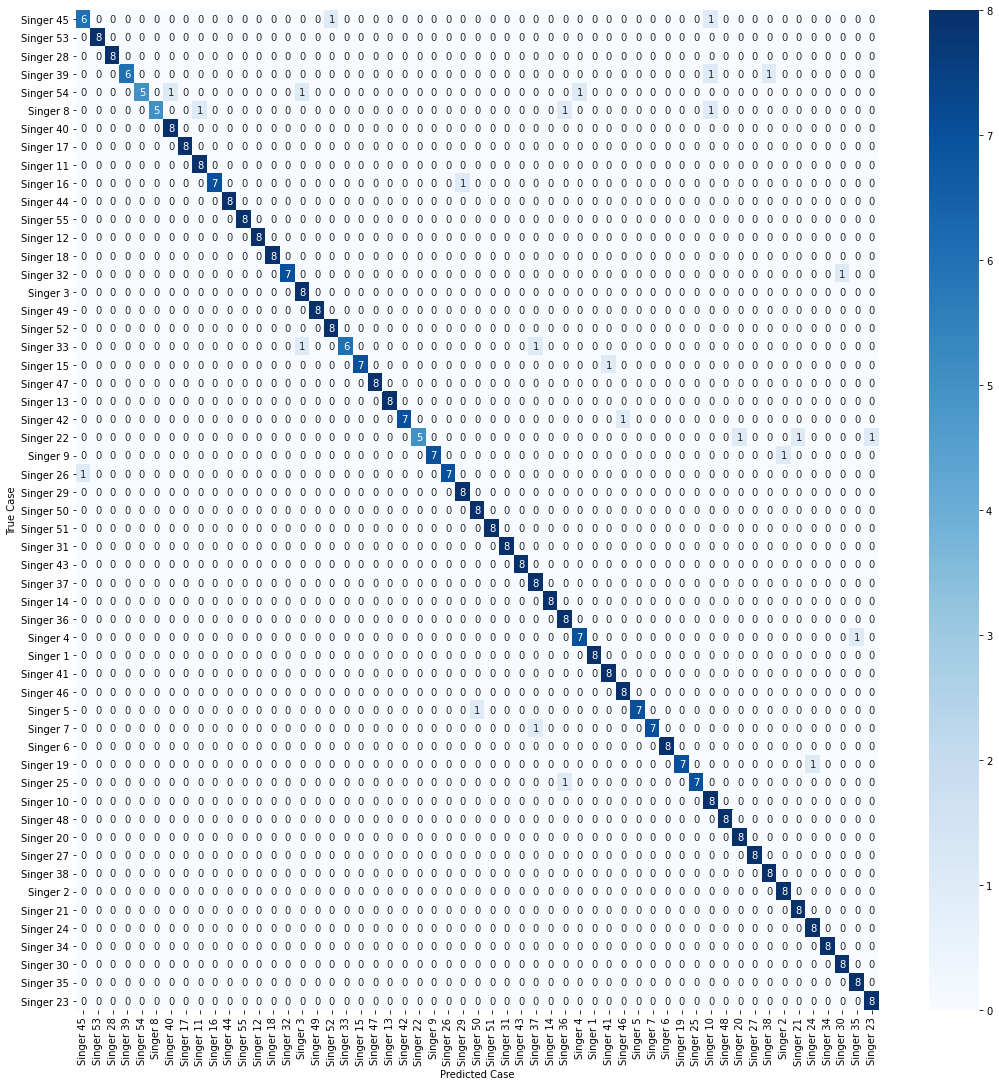

In [ ]:
# Getting correct labels
correct = list(map(lambda x: x[2], test_pool))

# Getting predictions
predictions = list(map(lambda x: np.argmax(x), signers_predictions))

# Labels
labels = list(map(lambda x: "Singer " + str(x), signers))

# Confusion Matrix
show_confussion_matrix(correct, predictions, labels, (15,15))

## Signature Classification

In [ ]:
print(signers)

[45, 53, 28, 39, 54, 8, 40, 17, 11, 16, 44, 55, 12, 18, 32, 3, 49, 52, 33, 15, 47, 13, 42, 22, 9, 26, 29, 50, 51, 31, 43, 37, 14, 36, 4, 1, 41, 46, 5, 7, 6, 19, 25, 10, 48, 20, 27, 38, 2, 21, 24, 34, 30, 35, 23]


//----- Signer #45 -----//
Model Accuracy: 0.875
Model Loss: 0.6186902523040771
[1, 1, 0, 1, 1, 0, 1, 0]
[1, 1, 0, 0, 1, 0, 1, 0]


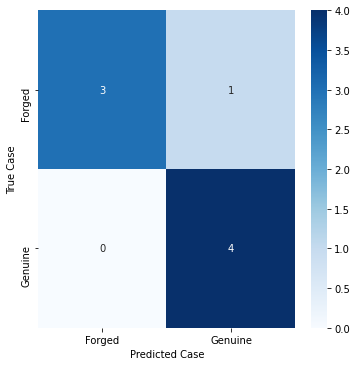



//----- Signer #53 -----//
Model Accuracy: 0.875
Model Loss: 8.868973731994629
[1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1]


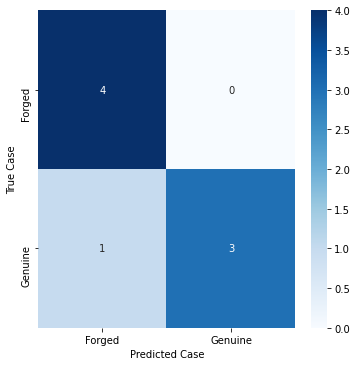



//----- Signer #28 -----//
Model Accuracy: 0.875
Model Loss: 1.6612128019332886
[1, 1, 1, 0, 1, 0, 0, 1]
[1, 1, 1, 0, 1, 0, 0, 0]


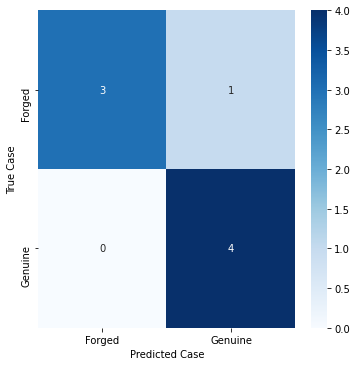



//----- Signer #39 -----//
Model Accuracy: 1.0
Model Loss: 0.15834394097328186
[1, 1, 1, 0, 1, 0, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 0]


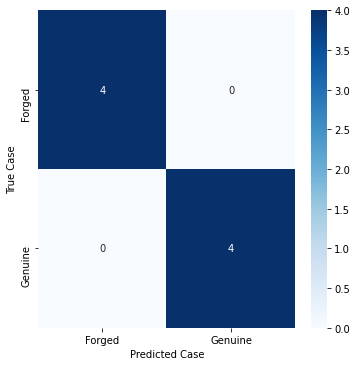



//----- Signer #54 -----//
Model Accuracy: 1.0
Model Loss: 0.022938508540391922
[1, 1, 0, 0, 1, 0, 1, 0]
[1, 1, 0, 0, 1, 0, 1, 0]


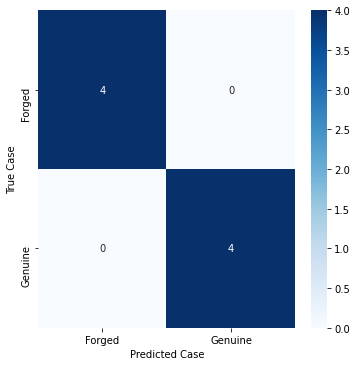



//----- Signer #8 -----//
Model Accuracy: 0.75
Model Loss: 0.6012805700302124
[1, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 1, 0, 1]


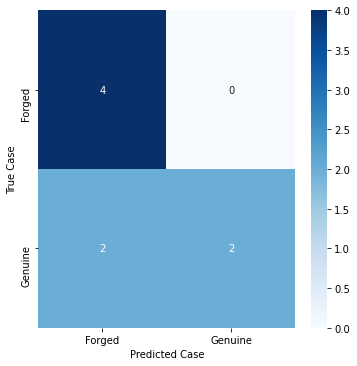



//----- Signer #40 -----//
Model Accuracy: 0.875
Model Loss: 0.6602973937988281
[0, 1, 0, 1, 0, 0, 1, 0]
[0, 1, 0, 1, 0, 1, 1, 0]


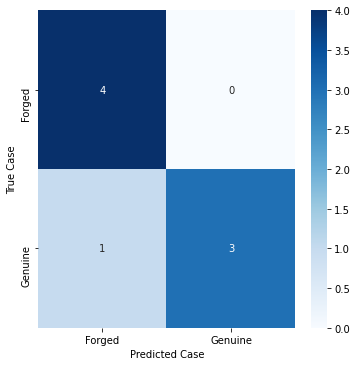



//----- Signer #17 -----//
Model Accuracy: 1.0
Model Loss: 6.6287084328486845e-12
[1, 0, 1, 1, 0, 0, 0, 1]
[1, 0, 1, 1, 0, 0, 0, 1]


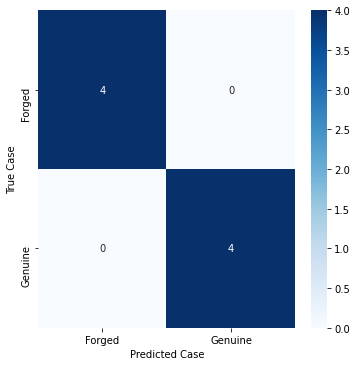



//----- Signer #11 -----//
Model Accuracy: 1.0
Model Loss: 1.1280582024042474e-09
[1, 1, 0, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 1, 0, 0]


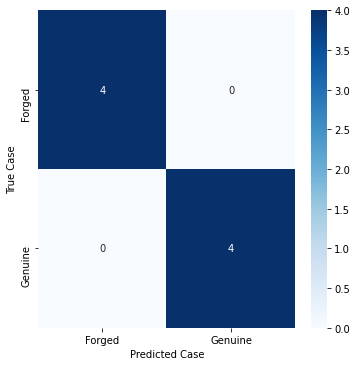



//----- Signer #16 -----//
Model Accuracy: 1.0
Model Loss: 1.5515011000388768e-06
[0, 1, 0, 1, 0, 1, 1, 0]
[0, 1, 0, 1, 0, 1, 1, 0]


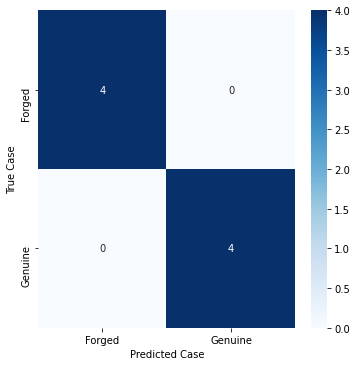



//----- Signer #44 -----//
Model Accuracy: 0.875
Model Loss: 0.44958600401878357
[0, 1, 0, 0, 0, 1, 0, 1]
[0, 1, 0, 0, 0, 1, 1, 1]


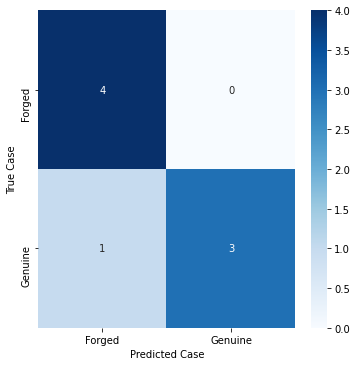



//----- Signer #55 -----//
Model Accuracy: 0.875
Model Loss: 1.4558758735656738
[0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 0, 1]


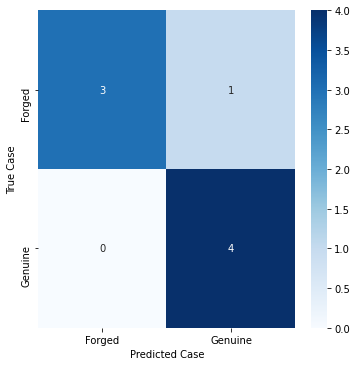



//----- Signer #12 -----//
Model Accuracy: 0.875
Model Loss: 0.1930834949016571
[1, 1, 1, 0, 1, 0, 1, 0]
[1, 1, 1, 0, 0, 0, 1, 0]


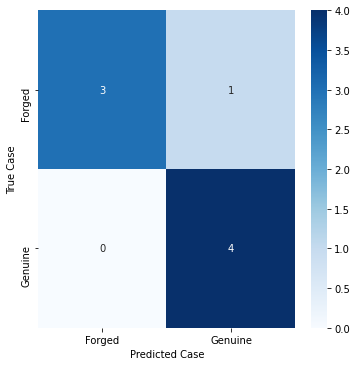



//----- Signer #18 -----//
Model Accuracy: 0.875
Model Loss: 0.44422903656959534
[1, 0, 1, 0, 0, 1, 1, 1]
[1, 0, 1, 0, 0, 1, 1, 0]


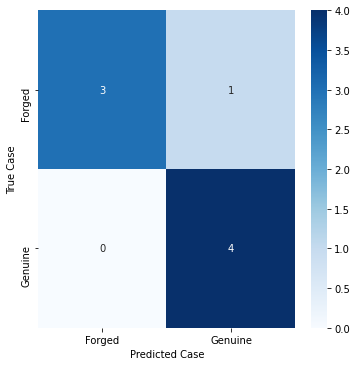



//----- Signer #32 -----//
Model Accuracy: 1.0
Model Loss: 7.224384383481681e-23
[0, 1, 0, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 1, 0]


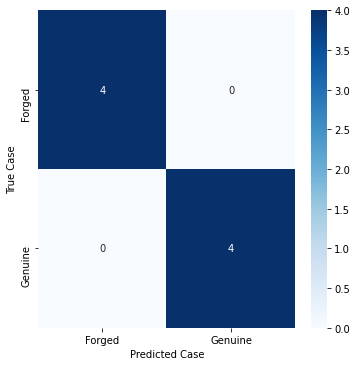



//----- Signer #3 -----//
Model Accuracy: 0.5
Model Loss: 4.746377468109131
[1, 1, 1, 1, 0, 1, 0, 1]
[0, 0, 1, 1, 1, 0, 0, 1]


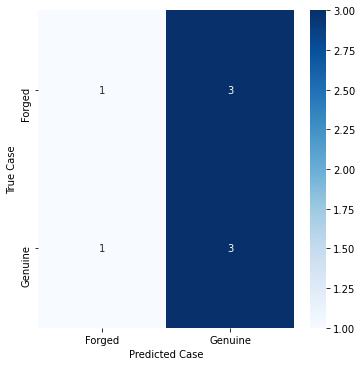



//----- Signer #49 -----//
Model Accuracy: 1.0
Model Loss: 0.0068584345281124115
[0, 0, 1, 0, 0, 1, 1, 1]
[0, 0, 1, 0, 0, 1, 1, 1]


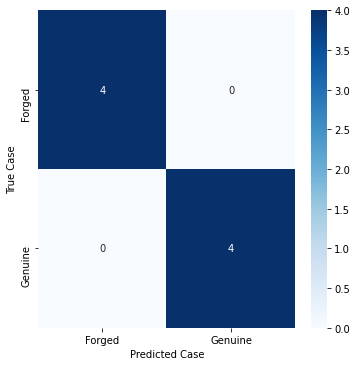



//----- Signer #52 -----//
Model Accuracy: 0.875
Model Loss: 40.48111343383789
[0, 1, 0, 1, 1, 0, 0, 0]
[0, 1, 0, 1, 1, 0, 0, 1]


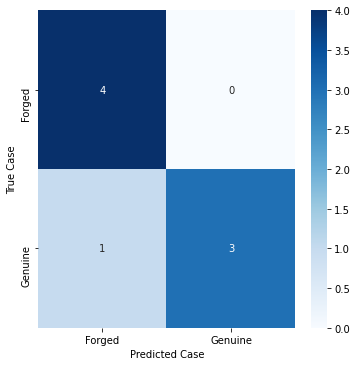



//----- Signer #33 -----//
Model Accuracy: 1.0
Model Loss: 0.05882519483566284
[0, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 1, 0, 1]


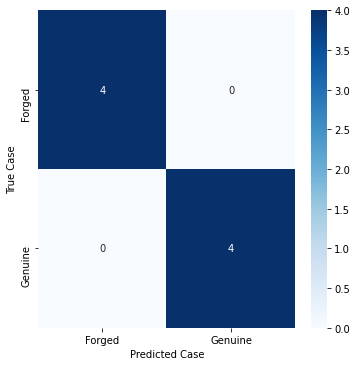



//----- Signer #15 -----//
Model Accuracy: 0.875
Model Loss: 6.766510963439941
[0, 1, 0, 0, 1, 1, 1, 1]
[0, 1, 0, 0, 1, 0, 1, 1]


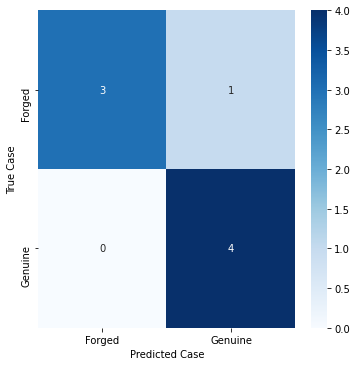



//----- Signer #47 -----//
Model Accuracy: 0.875
Model Loss: 0.3012082576751709
[0, 1, 1, 0, 1, 1, 0, 1]
[0, 1, 1, 0, 1, 0, 0, 1]


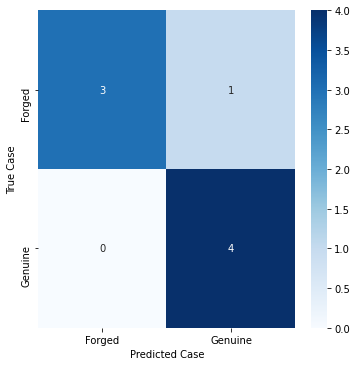



//----- Signer #13 -----//
Model Accuracy: 1.0
Model Loss: 2.453943916050762e-16
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 1, 1]


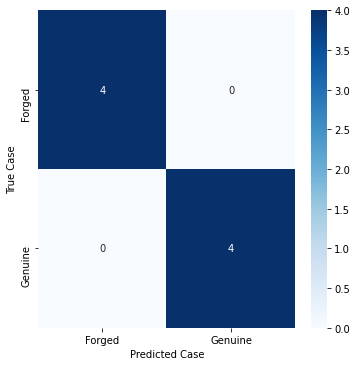



//----- Signer #42 -----//
Model Accuracy: 1.0
Model Loss: 0.16240130364894867
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 1, 1]


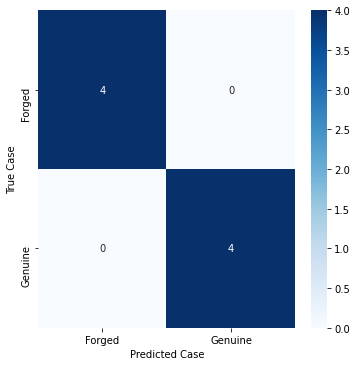



//----- Signer #22 -----//
Model Accuracy: 0.75
Model Loss: 0.533815860748291
[0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 1, 1, 0]


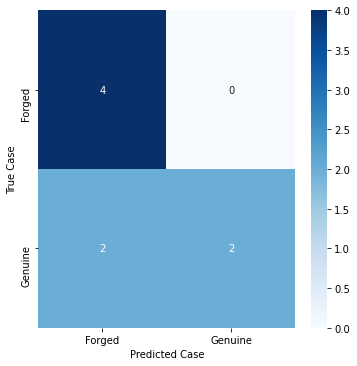



//----- Signer #9 -----//
Model Accuracy: 0.875
Model Loss: 2.3498218059539795
[1, 1, 1, 1, 0, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0]


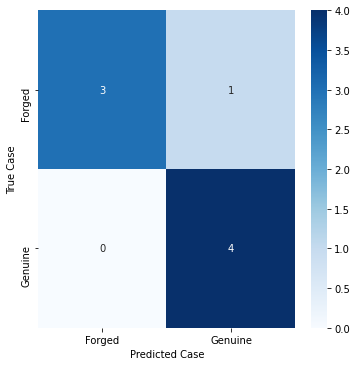



//----- Signer #26 -----//
Model Accuracy: 0.625
Model Loss: 0.6104758977890015
[1, 0, 0, 0, 0, 1, 0, 1]
[1, 1, 1, 0, 0, 0, 0, 1]


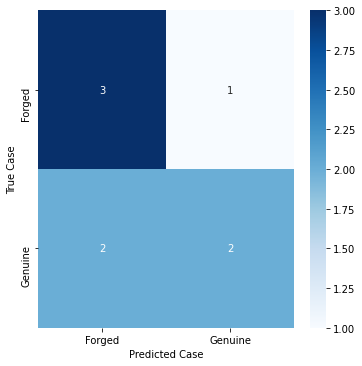



//----- Signer #29 -----//
Model Accuracy: 1.0
Model Loss: 1.5036422153506986e-14
[1, 0, 0, 1, 0, 0, 1, 1]
[1, 0, 0, 1, 0, 0, 1, 1]


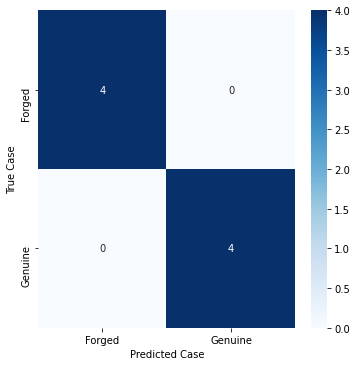



//----- Signer #50 -----//
Model Accuracy: 1.0
Model Loss: 0.0
[0, 1, 1, 1, 0, 0, 1, 0]
[0, 1, 1, 1, 0, 0, 1, 0]


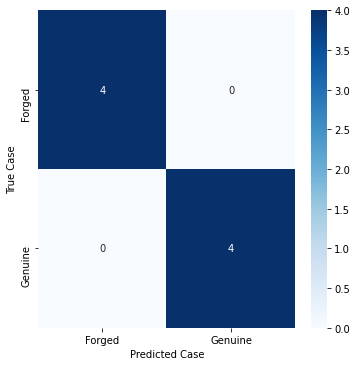



//----- Signer #51 -----//
Model Accuracy: 1.0
Model Loss: 2.937449589124341e-11
[1, 1, 0, 1, 0, 0, 1, 0]
[1, 1, 0, 1, 0, 0, 1, 0]


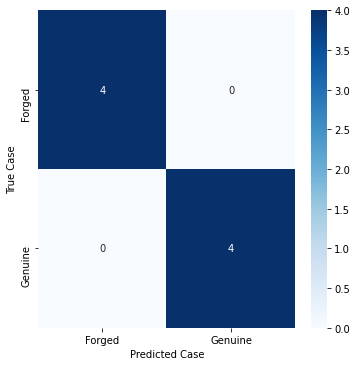



//----- Signer #31 -----//
Model Accuracy: 0.875
Model Loss: 0.14026539027690887
[1, 1, 0, 0, 0, 1, 1, 1]
[1, 1, 0, 0, 0, 1, 0, 1]


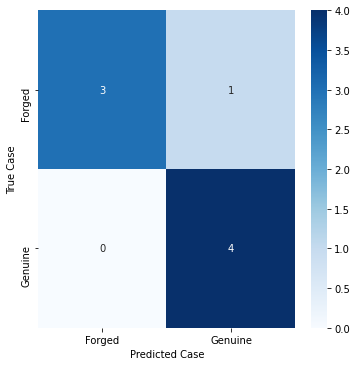



//----- Signer #43 -----//
Model Accuracy: 1.0
Model Loss: 3.2282905237934756e-08
[0, 1, 0, 0, 0, 1, 1, 1]
[0, 1, 0, 0, 0, 1, 1, 1]


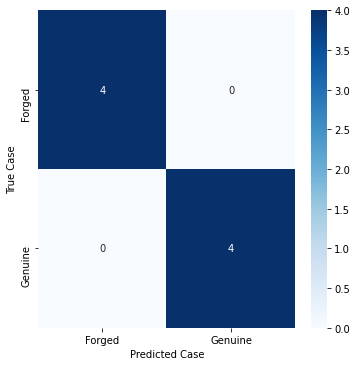



//----- Signer #37 -----//
Model Accuracy: 0.875
Model Loss: 14.627608299255371
[1, 0, 1, 1, 0, 1, 1, 0]
[1, 0, 1, 1, 0, 0, 1, 0]


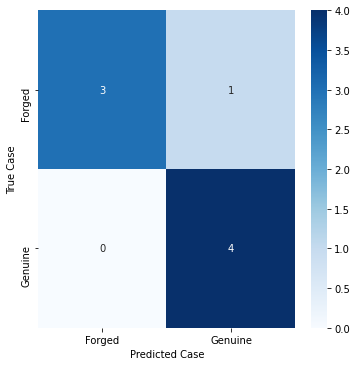



//----- Signer #14 -----//
Model Accuracy: 1.0
Model Loss: 0.02379191480576992
[1, 0, 0, 1, 1, 1, 0, 0]
[1, 0, 0, 1, 1, 1, 0, 0]


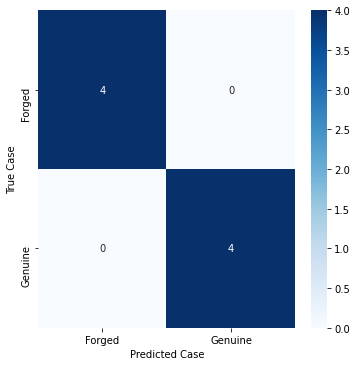



//----- Signer #36 -----//
Model Accuracy: 0.625
Model Loss: 7.145920753479004
[0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 1, 0, 0]


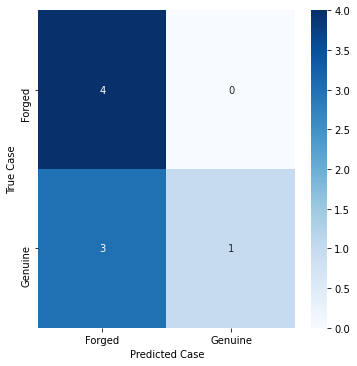



//----- Signer #4 -----//
Model Accuracy: 0.875
Model Loss: 0.308353453874588
[1, 0, 0, 0, 0, 1, 1, 0]
[1, 1, 0, 0, 0, 1, 1, 0]


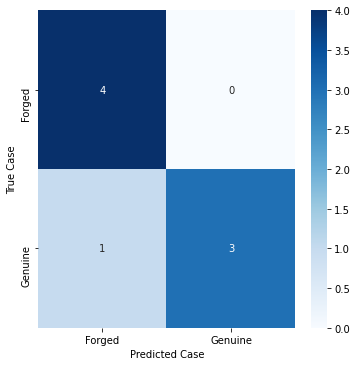



//----- Signer #1 -----//
Model Accuracy: 0.75
Model Loss: 1.2840052843093872
[0, 0, 1, 0, 0, 0, 1, 0]
[0, 1, 1, 0, 0, 0, 1, 1]


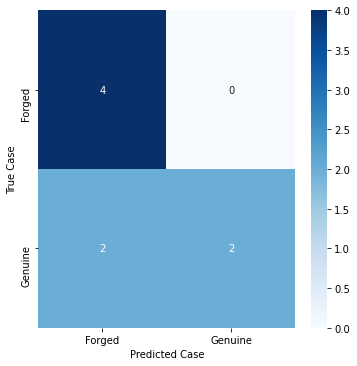



//----- Signer #41 -----//
Model Accuracy: 1.0
Model Loss: 0.030812513083219528
[1, 0, 1, 0, 0, 1, 1, 0]
[1, 0, 1, 0, 0, 1, 1, 0]


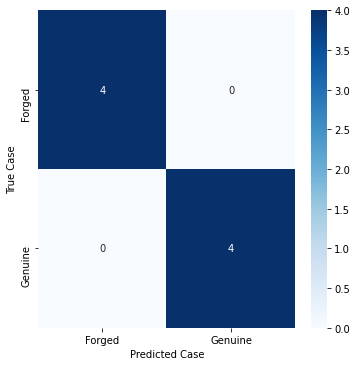



//----- Signer #46 -----//
Model Accuracy: 0.75
Model Loss: 1.5721598863601685
[1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 1, 1]


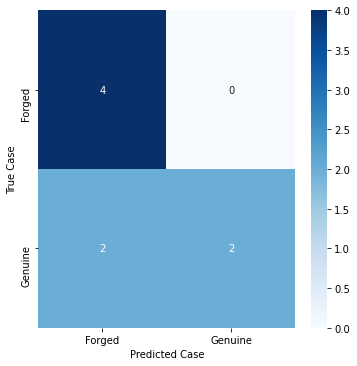



//----- Signer #5 -----//
Model Accuracy: 0.625
Model Loss: 5.294328689575195
[0, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 1, 1, 1]


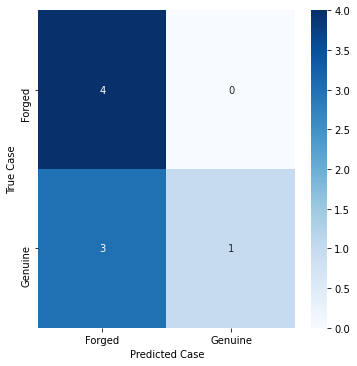



//----- Signer #7 -----//
Model Accuracy: 0.875
Model Loss: 0.20195260643959045
[0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 1, 0, 0, 1, 0, 1]


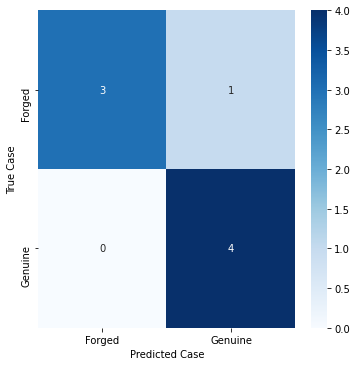



//----- Signer #6 -----//
Model Accuracy: 0.625
Model Loss: 1.1024360656738281
[1, 1, 1, 0, 0, 1, 1, 0]
[0, 1, 0, 1, 0, 1, 1, 0]


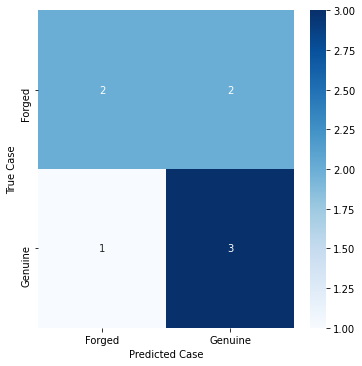



//----- Signer #19 -----//
Model Accuracy: 0.875
Model Loss: 60.29916763305664
[1, 0, 1, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 0, 0, 1, 1]


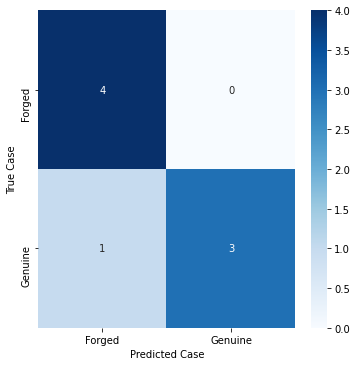



//----- Signer #25 -----//
Model Accuracy: 1.0
Model Loss: 0.02060163952410221
[1, 1, 0, 1, 0, 0, 0, 1]
[1, 1, 0, 1, 0, 0, 0, 1]


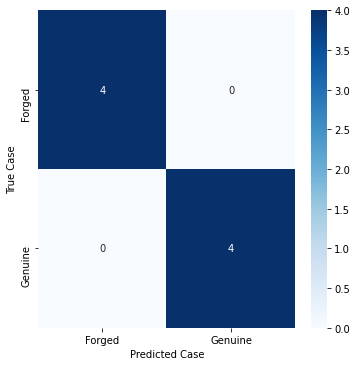



//----- Signer #10 -----//
Model Accuracy: 1.0
Model Loss: 1.43392674090137e-06
[1, 1, 0, 0, 0, 0, 1, 1]
[1, 1, 0, 0, 0, 0, 1, 1]


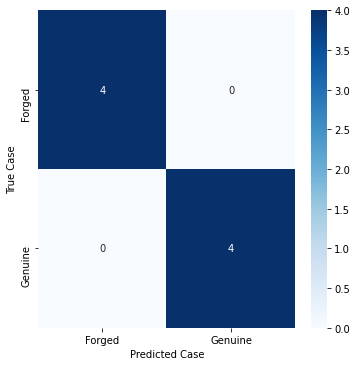



//----- Signer #48 -----//
Model Accuracy: 0.875
Model Loss: 0.5394341349601746
[1, 1, 1, 0, 0, 1, 0, 1]
[1, 1, 1, 0, 0, 1, 0, 0]


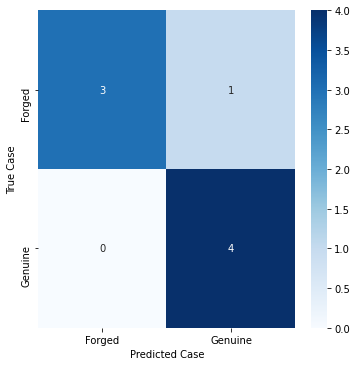



//----- Signer #20 -----//
Model Accuracy: 0.875
Model Loss: 1.2792980670928955
[0, 1, 0, 1, 0, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 1, 0]


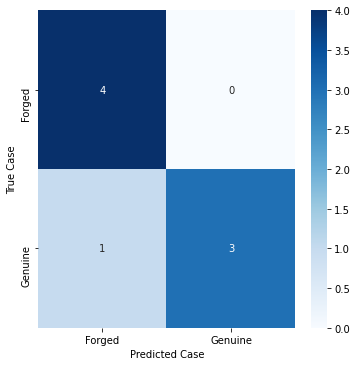



//----- Signer #27 -----//
Model Accuracy: 0.75
Model Loss: 0.26732590794563293
[1, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 1, 0, 0, 0, 1, 1]


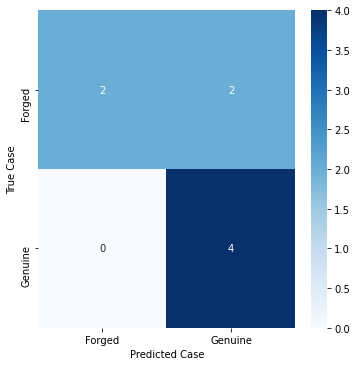



//----- Signer #38 -----//
Model Accuracy: 1.0
Model Loss: 0.007854586467146873
[1, 0, 1, 1, 0, 0, 1, 0]
[1, 0, 1, 1, 0, 0, 1, 0]


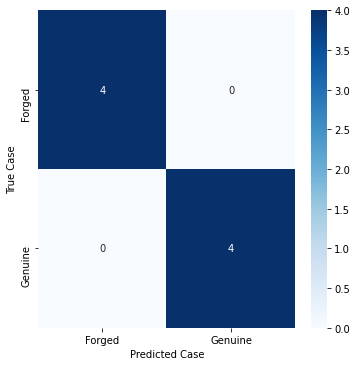



//----- Signer #2 -----//
Model Accuracy: 0.875
Model Loss: 0.09967221319675446
[1, 1, 1, 1, 0, 1, 0, 0]
[0, 1, 1, 1, 0, 1, 0, 0]


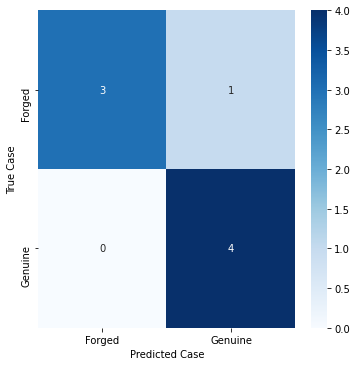



//----- Signer #21 -----//
Model Accuracy: 0.875
Model Loss: 0.27861639857292175
[0, 1, 0, 1, 1, 0, 1, 1]
[0, 1, 0, 1, 1, 0, 1, 0]


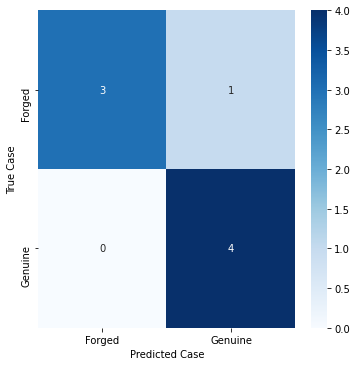



//----- Signer #24 -----//
Model Accuracy: 0.625
Model Loss: 2.4208314418792725
[1, 1, 1, 1, 0, 1, 1, 1]
[1, 0, 1, 1, 0, 0, 1, 0]


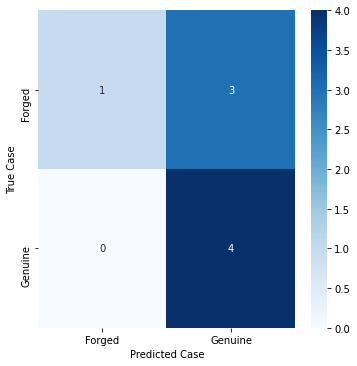



//----- Signer #34 -----//
Model Accuracy: 1.0
Model Loss: 0.01812339574098587
[1, 1, 0, 0, 0, 0, 1, 1]
[1, 1, 0, 0, 0, 0, 1, 1]


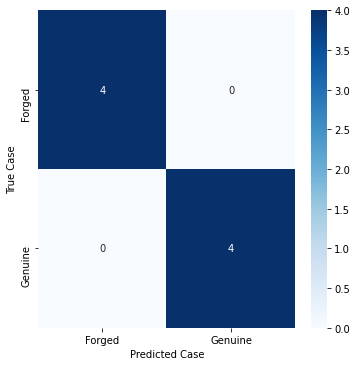



//----- Signer #30 -----//
Model Accuracy: 0.875
Model Loss: 0.11407187581062317
[1, 0, 1, 1, 0, 1, 0, 1]
[1, 0, 1, 1, 0, 1, 0, 0]


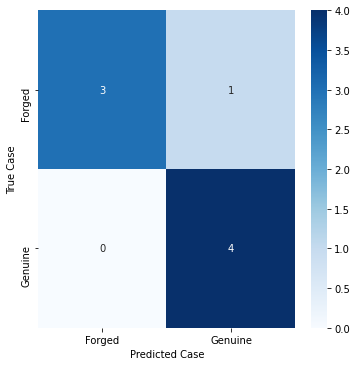



//----- Signer #35 -----//
Model Accuracy: 0.875
Model Loss: 0.21389006078243256
[0, 1, 1, 1, 1, 0, 0, 1]
[0, 0, 1, 1, 1, 0, 0, 1]


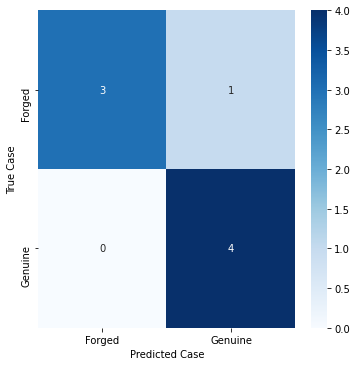



//----- Signer #23 -----//
Model Accuracy: 0.875
Model Loss: 0.1368986964225769
[1, 0, 1, 0, 1, 1, 0, 1]
[1, 0, 1, 0, 1, 1, 0, 0]


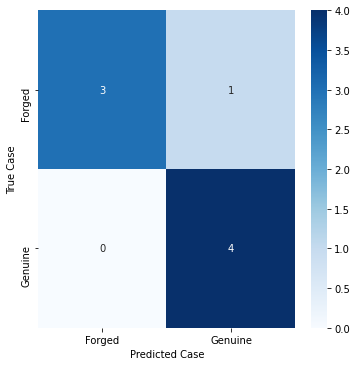



Average Accuracy: 0.8795454545454545


In [ ]:
# Show each model's accuracy and then show an average
# Accuracies
average = 0
for i in range(len(signers)):
  print("//----- Signer #" + str(signers[i]) + " -----//")
  print("Model Accuracy: " + str(signatures_evaluations[i][1]))
  print("Model Loss: " + str(signatures_evaluations[i][0]))
  average += signatures_evaluations[i][1]
  predictions = list(map(lambda x: 1 if x >= 0.5 else 0, signatures_predictions[i]))
  print(predictions)
  print(signatures_correct_labels[i])
  show_confussion_matrix(signatures_correct_labels[i], predictions, ["Forged", "Genuine"], (5,5))
  print("\n")

average /= len(signers)
print('Average Accuracy: ' + str(average))